<img src="https://drive.google.com/uc?id=1YLNtm8gNsviTEnVXzfiby2VMKrc0XzLP" width="500"/>

---


# **Generative Adversarial Networks (GANs)**

#### **Morning contents/agenda**

1. Why GANs?

2. Recap of generative models and VAEs

3. Formulation and training strategy

4. Implemention of a simple GAN

5. Pros and cons

6. Overview of main GAN flavours

<br>

#### **Learning outcomes**

1. Understand the basic principles of adversarial traning (with two competing networks)

2. Implementa a Generator and a Discriminator and train them with a simple GAN

3. Be aware of the importance of GANs in deep learning, its many variations, benefits, and limitations

<br>

#### **Afternoon contents/agenda**

1. Conditional GANs

2. Wasserstein GANs theory and implementation example. Materials provided for Wasserstein GAN (for information only, **you will NOT be assessed on WGANs**)

<br>

#### **Learning outcomes**

1. Understand how Conditional GANs can be used to generate samples of a specific class

<br/>

---

<br/>

In [1]:
!pip install livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Conditional Generative Adversarial Networks (cGANs)

Conditional GANs (cGANs) enables the generation of realistic data that matches the given labels -- greatly improves the value of GANs in real practises.

In our MNIST case, we can adapt the GAN architecture from the morning lecture to generate number-specific images (e.g. 1000 images of the number 5)

cGANs were introduced in [this](https://arxiv.org/abs/1411.1784) paper. In this exercise we will implement this architure to include labels of MNIST in our generator. The architecture of cGANs is shown below:

![](https://miro.medium.com/max/700/1*Vjo1df-yPFks2e_-TbdWdQ.png)

Image credit: [medium blog](https://medium.com/@ma.bagheri/a-tutorial-on-conditional-generative-adversarial-nets-keras-implementation-694dcafa6282)




In [3]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import random
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


## Train a conditional GAN

**How to put label into the network?**
* **Simply concatenate the label with the input of the network**

Starting with a latent vector of length 128, the conditioning vector will have size 10 (number of classes) with the value of 1 at the index of the class and 0 elsewhere. Therefore, the input of the generator network will be of size 128 + 10 = 138, and the input of the discriminator network



### Task 1: Create the conditional Network
**Latent vector length**: 128 | **Length of the conditioning vector**: 10

**Network G:**

0. Concatenate `z` and `label` using torch.cat()
1. Layer 1 for the latent vector: 128 + 10 -> 256
2. Layer 2 for the label vector: 256 -> 512
3. Layer 2: 512 -> 1024
4. Layer 4: 1024 -> 784 (size of a MNIST image)

Apply ``LeakyReLU(0.2)`` activation functions for layers 1-3, and ``TanH`` to the final layer.

**Network D:**

0. Concatenate `x` and `label` here using torch.cat()
1. Layer 1: 794 -> 1024
2. Layer 2: 1024 -> 512
3. Layer 3: 512 -> 256
4. Layer 4: 256 -> 1


Apply ``LeakyReLU(0.2)`` activation functions for layers 1-3, and ``Sigmoid`` to the final layer.

In [4]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(g_input_dim + num_classes, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
        self.activation = nn.LeakyReLU(0.2)

    # forward method
    def forward(self, z, label):
        z = torch.cat([z, label], 1)   # 将两个张量 z 和 label 在第一个维度（横向，即列）上拼接。
        x = self.activation(self.fc1(z))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        return torch.tanh(self.fc4(x))


class Discriminator(nn.Module):
    def __init__(self, d_input_dim, num_classes):
        super().__init__()  # 用于初始化 nn.Module 中定义的所有必要的基础功能。
        self.fc1 = nn.Linear(d_input_dim + num_classes, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        self.activation = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.3)    # We regularise the discriminator by adding dropout so it doesn't memorise the training data


    # forward method
    def forward(self, x, label):
        x = torch.cat([x, label], 1)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.dropout(x)
        return torch.sigmoid(self.fc4(x))


# Build model
z_dim = 128
x_dim = 28*28
num_classes = 10

G = Generator(z_dim, x_dim, num_classes).to(device)
D = Discriminator(x_dim, num_classes).to(device)

# Test output
G(torch.randn(10, z_dim).to(device), torch.randn(10, num_classes).to(device)).shape, D(torch.randn(10, x_dim).to(device), torch.randn(10, num_classes).to(device)).shape

(torch.Size([10, 784]), torch.Size([10, 1]))

### Task 2: Create the dataloader and optimisers with the following hyperparameters

**Dataloader**

- MNIST train dataset

- ``batch_size=64``

- Normalise the data to the range [-1, 1]

**Optimiser**

- ``Adam`` with ``learning_rate = 2e-4``



In [6]:
torch.autograd.Function
# torch.nn.Module

torch.autograd.function.Function

In [11]:
params = list(G.parameters())  # 将生成器转为列表
x = params[1]  # 获取第 2 个参数（假设是想研究第二个参数）
print(x.shape)

torch.Size([256])


In [14]:
param_gen = G.parameters()
next(param_gen)  # 获取第一个参数，跳过
x = next(param_gen)  # 获取第二个参数
print(x.shape)

torch.Size([256])


In [9]:
G.parameters()

<generator object Module.parameters at 0x7a3c427027a0>

In [7]:
# Loss function
criterion = nn.BCELoss()

# Optimisers
lr = 0.0002
G_optimiser = torch.optim.Adam(G.parameters(), lr = lr)
D_optimiser = torch.optim.Adam(D.parameters(), lr = lr)

In [8]:
# MNIST Dataset
batch_size=64
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])
torch.autograd.Function
torch.nn.Module

train_dataset = MNIST(root='./mnist_data/', train=True, transform=transform, download=True)

# Data Loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.39MB/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.26MB/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



### Task 3: Adapt the ``D_train`` and ``G_train`` functions to take in the conditioning.
**Note**: Think about how you need to format the class labels from the data loader to the class vectors ``(batch_size, num_classes)`` required for conditioning

In [9]:
def D_train(x, cond):
    #-------------- Function of the discriminator training -------------------#
    D.train()   #D来自于 D = Discriminator(x_dim, num_classes).to(device)
    D_optimiser.zero_grad()

    bs = x.shape[0]  # batch size

    # Create conditioning vector for real data of size (bs, num_classes)
    c = torch.zeros(bs, num_classes)
    c.scatter_(1, cond.view(bs, 1), 1) # Fills the tensor using the class labels
    c = c.to(device)


    # Real data reshaped -- label for all real samples is 1
    x_real, y_real = x.view(-1, 28*28), torch.ones(bs, 1)
    x_real, y_real = x_real.to(device), y_real.to(device)

    # Training loss for real data
    D_output = D(x_real, c)
    D_real_loss = criterion(D_output, y_real)

    # Create conditioning vector for fake data of size (bs, num_classes)
    c = torch.zeros(bs, num_classes)
    c.scatter_(1, torch.randint(low=0, high=10, size=(bs, 1)), 1) # Fills the tensor using random class labels
    c = c.to(device)

    # Sample vector and generation of fake data -- label for all fake samples is 0
    z = torch.randn(bs, z_dim).to(device)
    x_fake, y_fake = G(z, c), torch.zeros(bs, 1).to(device)

    # Training loss for fake fata
    D_output = D(x_fake.detach(), c)
    D_fake_loss = criterion(D_output, y_fake)

    # Combine the losses
    D_loss = D_real_loss + D_fake_loss

    # Backpropagate and model update
    D_loss.backward()
    D_optimiser.step()


    return  D_loss.data.item() #返回的值是判别器的损失值 D_loss 的 数值形式，通常是一个浮点数。


In [10]:
def G_train(x):
    #-------------- Function of the generator training -------------------#
    G.train()
    G_optimiser.zero_grad()

    bs = x.shape[0]

    # Create conditioning vector for fake data of size (bs, num_classes)
    c = torch.zeros(bs, num_classes)
    c.scatter_(1, torch.randint(low=0, high=10, size=(bs, 1)), 1) # Fills the tensor using random class labels
    c = c.to(device)

    # Sample vector and generation of fake data
    z = torch.randn(bs, z_dim).to(device)
    x_fake = G(z, c)

    # To "fool" the discriminator, fake data labels are set to 1
    y = torch.ones(bs, 1).to(device)

    # Training loss of the generator
    D_output = D(x_fake, c)
    G_loss = criterion(D_output, y)

    # Backpropagate and model update
    G_loss.backward()
    G_optimiser.step()

    return G_loss.data.item()

### Task 4: Adapt the training function to take in the appropriate conditioning and train the model

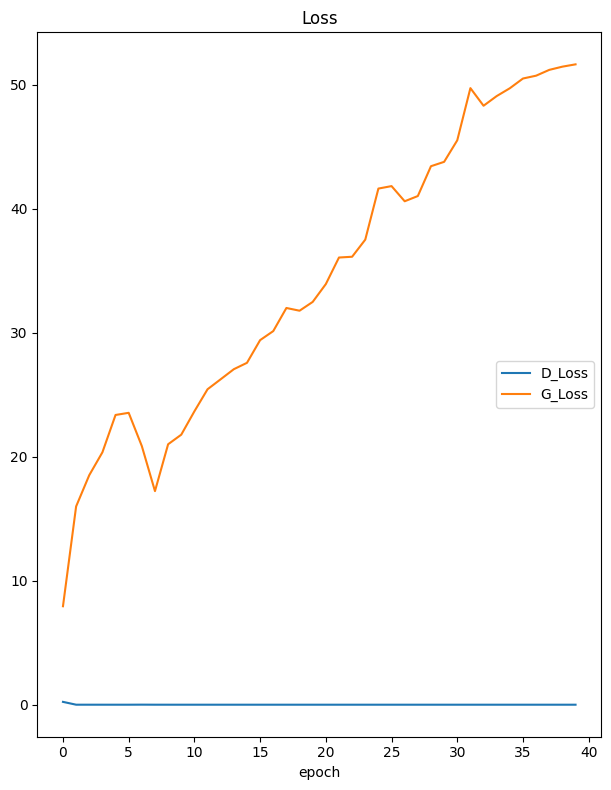

Loss
	D_Loss           	 (min:    0.000, max:    0.228, cur:    0.000)
	G_Loss           	 (min:    7.942, max:   51.647, cur:   51.647)


In [ ]:
n_epoch = 100
groups = {'Loss': ['D_Loss', 'G_Loss']}
liveloss = PlotLosses(groups=groups)

for epoch in range(1, n_epoch+1):
    d_loss_epoch, g_loss_epoch = 0, 0
    logs = {}
    for batch_idx, (x, labels) in enumerate(train_loader):
        d_loss_epoch += D_train(x, labels)
        g_loss_epoch += G_train(x)
    logs['D_Loss'] = d_loss_epoch / len(train_loader)
    logs['G_Loss'] = g_loss_epoch / len(train_loader)
    liveloss.update(logs)
    liveloss.draw()


    # save every 20th epochs
    if(np.mod(epoch, 20) == 0):
        torch.save(G.state_dict(), "./Generator_{:03d}.pth".format(epoch))

### Task 5: Use the trained generator to generate 10 images of each class

In [ ]:
# epoch = 100
# G.load_state_dict(torch.load("./Generator_{:03d}.pth".format(epoch)))

with torch.no_grad():
    # Random vector
    z = torch.randn(100, z_dim).to(device)

    # Conditioning from 0 to 10
    z_label = torch.zeros(100, 10)
    z_labels = torch.LongTensor([i for i in range(10) for _ in range(10)])
    z_label.scatter_(1, z_labels.view(100, 1), 1)

    # Generate images
    generated = G(z, z_label.to(device))

# Plot
fig, axarr = plt.subplots(10, 10, figsize=(12, 12))
for ax, img in zip(axarr.flatten(), generated.view(generated.size(0), 28, 28).cpu()):
  ax.imshow(img, cmap="gray")
plt.show()